In [1]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os

In [3]:
train = pd.read_csv('./data/House Prices/train.csv')
test = pd.read_csv('./data/House Prices/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


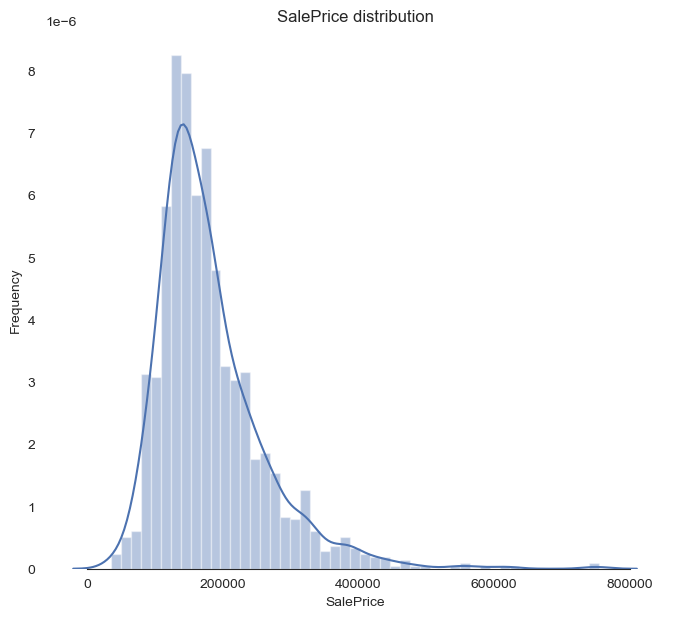

In [34]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

In [42]:
print(f"Skewness: {train['SalePrice'].skew():.5f}")
print(f"Kurtosis: {train['SalePrice'].kurt():.5f}")

Skewness: 1.88288
Kurtosis: 6.53628


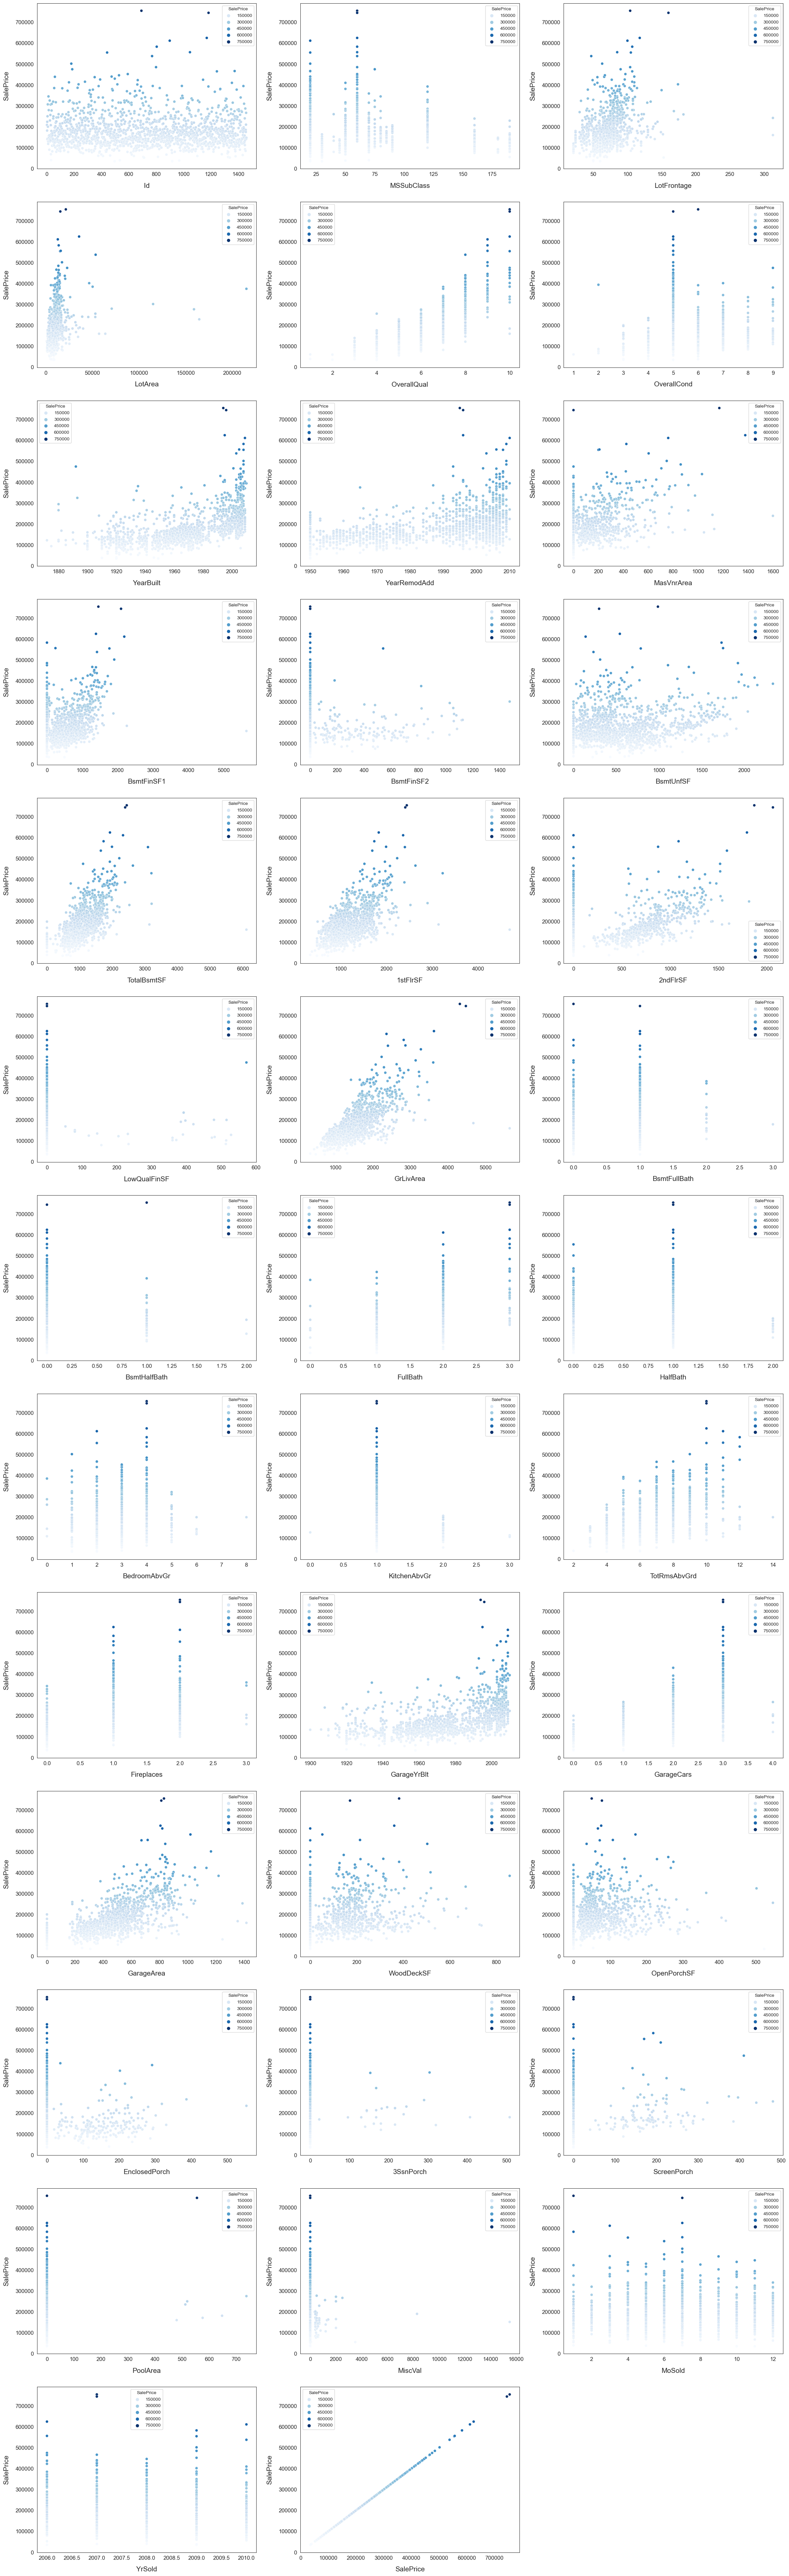

In [72]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for col in train.columns:
    if train[col].dtype in numeric_dtypes:
        numeric.append(col)
# len(numeric) = len(train.describe().columns)

fig, ax = plt.subplots(figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette('husl', 8)
for i, feature in enumerate(list(train[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)

    plt.xlabel(feature, size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

plt.show()


<AxesSubplot:>

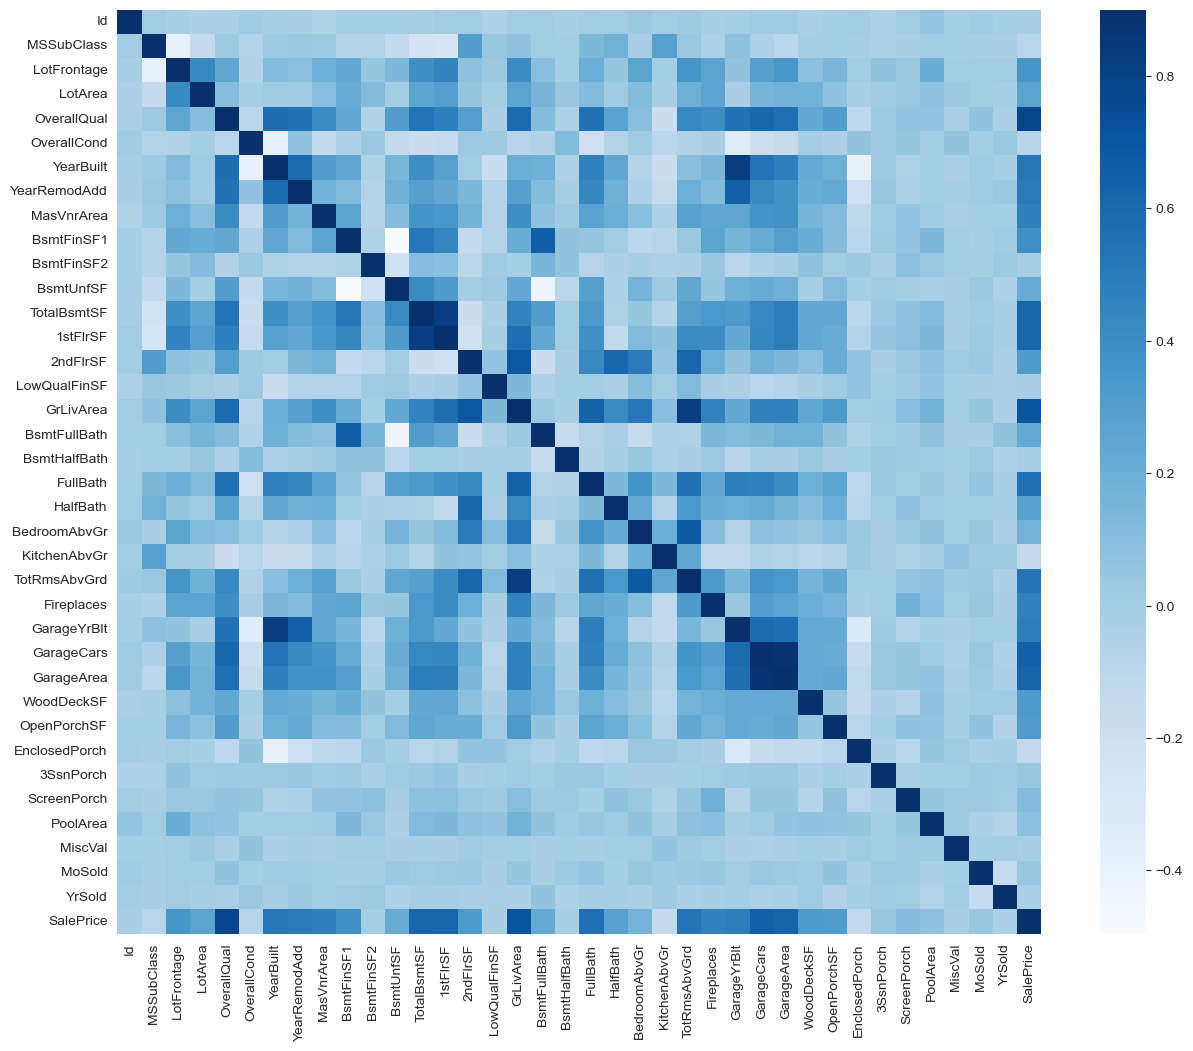

In [75]:
corr = train.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=0.9, cmap='Blues', square=True)